In [ ]:
!pip install matplotlib

In [10]:
import os
import time
import random
import numpy as np
from pyspark import SparkConf, SparkContext
import matplotlib.pyplot as plt
import sys
import pyspark

### EXERCISE 1
Using the labelled dataset “botnet_tot_syn_l.csv”, implement a parallel version of the logistic regression
classifier on Spark with Python.
Implement parallel versions of readFile, normalize, train and accuracy functions:

In [18]:
def readFile(filename, sc):
    """
    Return an RDD containing the data of filename.
    Each example (row) of the file corresponds to one RDD record.
    Each record of the RDD is a tuple (X,y). “X” is an array containing the 11
    features (float number) of an example.
    “y” is the 12th column of an example (integer 0/1).
    """
    # 1. Use os.path.join for platform-independent path construction
    file_path = os.path.join(os.getcwd(), filename)
    
    # 2. Load data
    data = sc.textFile(file_path)
    
    # 3. Process data: Split, convert features to list of floats, and 
    processed_data = data.map(lambda line: line.split(",")).map(
        lambda cols: (
            [float(x) for x in cols[:11]], # X: 11 features (list of floats)
             int(cols[11])                 # y: 12th column (integer 0/1)
        )
    )
    return processed_data

In [19]:
def normalize(Xyrdd, sc):
    """
    Normalize feature columns of an RDD of (X, y) to N(0, 1).
    Input:  RDD [([x1,...,xk], y), ...] (k=11 features)
    Output: RDD [([z1,...,zk], y), ...] with z = (x - mean) / std, 
            plus the calculated mean and std vectors.
    """

    # 1. Prepare RDD for global statistic calculation (Map phase of aggregation) 
    features = Xyrdd.map(lambda row: np.asarray(row[0]))

    # 2. Compute sums and sums-of-squares in parallel (Reduce phase)
    n = Xyrdd.count()
    sum_vec = features.reduce(lambda a, b: a + b)
    sum_sq_vec = features.map(lambda x: x * x).reduce(lambda a, b: a + b)

    # 3. Calculate mean and standard deviation vectors (Driver calculation)
    mean = sum_vec / n
    # Variance: E[X^2] - (E[X])^2
    var = (sum_sq_vec / n) - (mean ** 2)
    std = np.sqrt(var)
    
    # Handle constant feature columns to prevent division by zero
    std[std == 0] = 1.0

    # 4. Broadcast global statistics to all worker nodes (Efficiency step)
    bc_mean = sc.broadcast(mean)
    bc_std = sc.broadcast(std)

    # 5. Normalize data (Second pass / Map transformation)
    data_normalized = Xyrdd.map(
        lambda row: (
            (np.asarray(row[0]) - bc_mean.value) / bc_std.value, 
            row[1]
        )
    )

    # Return normalized RDD and the statistics for future use (e.g., test data)
    return data_normalized, mean, std

In [20]:
def train(data, nIter, learning_rate, lambda_reg, sc):
    """
    Performs parallelized Gradient Descent for Logistic Regression.
    """
    np.random.seed(42)       # For reproducibility
    k = len(data.first()[0]) # number of features
    n = data.count()         # number of samples

    # Initialization
    w = np.random.rand(k)    # Weight vector
    b = np.random.rand()     # Bias term

    history_cost = []
    sample_every = 1 

    for i in range(nIter):
        # 1. Broadcast current parameters to all executors
        bc_w = sc.broadcast(w)
        bc_b = sc.broadcast(b)

        # 2. Parallel Gradient Calculation: Map computes local gradients (dw, db) for each sample,
        gradients = data.map(
            lambda sample: compute_gradients(sample, bc_w.value, bc_b.value)
        ).reduce(
            lambda a, b: (a[0] + b[0], a[1] + b[1])
        )

        # 3. Apply Gradient Descent and Regularization 
        w_reg_update = lambda_reg / k * w
        w -= learning_rate * ((1 / n * gradients[0]) + w_reg_update)
        b -= learning_rate * (1 / n * gradients[1])

        # 4. Compute and print the Cost Function
        if i % sample_every == 0:
            sum_of_losses = data.map( 
                lambda x: compute_cost(x, bc_w.value, bc_b.value)
            ).reduce(
                lambda x, y: x + y
            )
            cost = (-1.0 / n) * sum_of_losses + (lambda_reg / (2.0 * k)) * np.sum(w**2)
            
            history_cost.append(cost)
            print(f"Iteration {i}: Cost = {cost}")
    
    return w, b, history_cost


# Helper function to calculate gradients for a single sample
def compute_gradients(sample, w, b):
    
    # Ensure X is a NumPy array for vectorized operation
    X, y = np.asarray(sample[0]), sample[1] 
    
    # 1. Linear combination (Vectorized)
    z = np.dot(X, w) + b
    
    # 2. Sigmoid prediction
    y_hat = 1.0 / (1.0 + np.exp(-z))
    
    # 3. Error term
    error = y_hat - y
    
    # 4. Local Gradients (Vectorized)
    dw = error * X 
    db = error
    
    return dw, db


# Helper function to calculate the cost (loss) for a single sample
def compute_cost(sample, w, b):
    
    # Ensure X is a NumPy array for vectorized operation
    X, y = np.asarray(sample[0]), sample[1] 
    
    # 1. Linear combination
    z = np.dot(X, w) + b
    
    # 2. Sigmoid prediction
    y_hat = 1.0 / (1.0 + np.exp(-z))

    # 3. Binary Cross-Entropy Loss for one sample (Vectorized)
    cost = y * np.log(y_hat) + (1 - y) * np.log(1.0 - y_hat)
    
    return cost

In [21]:
def predict(w, b, X, threshold=0.5):
    """
    Predicts the class label (0 or 1) for a single example X.
    """
    # Ensure X is a NumPy array for vectorized operation
    X_arr = np.asarray(X) 
    
    # z = w · X + b
    z = np.dot(w, X_arr) + b

    # Apply the sigmoid function to get the probability p
    p = 1.0 / (1.0 + np.exp(-z))
    
    # Return the prediction (0 or 1)
    y_pred = 1 if p >= threshold else 0
    
    return y_pred

def accuracy(w, b, XyRDD, sc):
    """
    Calculates the classification accuracy of the model (w, b) on the data in XyRDD.
    """
    
    # Map: For each sample, predicts the label and returns 1 if prediction matches the true label (sample[1]), else 0.
    correct = XyRDD.map(
        lambda sample: 1 if predict(w, b, sample[0]) == sample[1] else 0
    ).reduce(
        lambda x, y: x + y
    )
    
    # Calculate accuracy: (Total correct predictions) / (Total number of records)
    return correct / XyRDD.count()

In [22]:
# Cleanup at the start of each experiment
try:
    data_cache.unpersist()
    sc.stop()
    print("SparkContext stopped successfully")
except:
    pass
# -----------------------------------------------

# exercise 1
conf = SparkConf().setAppName("Parallel_LR_Assessment")
sc = SparkContext.getOrCreate(conf=conf)
filename = "botnet_reduced_l.csv"    

start_time = time.time()
# read data
data = readFile(filename, sc)

# standardize
data, _, _ = normalize(data, sc)

w, b, _ = train(data, 5, 1.5, 0.05, sc)

end_time = time.time()
acc = accuracy(w, b, data, sc)

Iteration 0: Cost = 1.5384774795821805


Iteration 1: Cost = 0.7786959893595409


Iteration 2: Cost = 0.48870734366047086


Iteration 3: Cost = 0.36918050111859896


Iteration 4: Cost = 0.312773622887825


In [23]:
print("time needed: ", end_time - start_time, "seconds")
print("acc: ", acc)

time needed:  76.30742621421814 seconds
acc:  0.90711


### EXERCISE 2
Implement a procedure to perform cross validation 

You can read the file from disk only once.

In [24]:
def transform(XyRDD, group_number):
    # For reproducibility
    random.seed(42)
    # Shuffle the RDD by assigning a random key and sorting
    shuffled_rdd = XyRDD.map(lambda x: (random.random(), x)).sortByKey().map(lambda x: x[1])
    
    # Assign an index to each sample, then a group number (0 - group_number-1) for group_number groups
    grouped_rdd = shuffled_rdd.zipWithIndex().map(lambda x: (x[0], x[1] % group_number))
    return grouped_rdd

In [25]:
def test_normalize(XyRDD, mean, std, sc):
    """
    Normalize feature columns of the test set with the mean and std passed as parameters.
    Input: RDD [([x1,...,xk], y), ...] (unnormalized test data)
    Output: RDD [([z1,...,zk], y), ...] (normalized test data)
    """

    # Ensure zero standard deviations are handled before broadcasting. 
    # (Though ideally handled right after the training set's std calculation.)
    std[std == 0] = 1.0

    # Broadcast statistics derived from the training set
    bc_mean = sc.broadcast(mean)
    bc_std = sc.broadcast(std)

    # Apply Z-score normalization to every test sample in parallel
    data_normalized = XyRDD.map(
        lambda row: ((np.asarray(row[0], dtype=float) - bc_mean.value) / bc_std.value, row[1]))
    return data_normalized

In [26]:
def get_block_data(XyRDD, i):

  test_data = XyRDD.filter(lambda x: x[1] == i).map(lambda x: x[0]) # keeping only x[0] to remove the index I have previously added
  tr_data = XyRDD.filter(lambda x: x[1] != i).map(lambda x: x[0])

  return tr_data, test_data

In [27]:
# Cleanup at the start of each experiment
try:
    data_cache.unpersist()
    sc.stop()
    print("SparkContext stopped successfully")
except:
    pass
# -----------------------------------------------
conf = SparkConf().setAppName("Parallel_LR_Assessment")
sc = SparkContext.getOrCreate(conf=conf)
filename = "botnet_reduced_l.csv" 

# exercise 2
num_blocks_cv = 5
nIter = 3
learningRate = 1.5
lambdarg = 0.05
accs = []

# Shuffle rows and transform data, specifying the number of blocks
data_cv = transform(data, num_blocks_cv)

# This prevents random transformation at each loop
data_cv.cache()
data_cv.count()

# Starting the time
start_time = time.time()

for i in range (num_blocks_cv):

    tr_data, test_data = get_block_data(data_cv, i)
    tr_data, tr_mean, tr_std = normalize(tr_data, sc)
    test_data = test_normalize(test_data, tr_mean, tr_std, sc)

    w, b, _ = train(tr_data, nIter, learningRate, lambdarg, sc)
    acc = accuracy (w, b, test_data, sc)
    accs.append(acc)
    print ("acc:", acc)

    
end_time = time.time()

25/12/09 18:13:42 WARN BlockManager: Task 97 already completed, not releasing lock for rdd_26_0
                                                                                

Iteration 0: Cost = 1.53749054433423


Iteration 1: Cost = 0.7792971343250117


Iteration 2: Cost = 0.489383116199917


acc: 0.851775


25/12/09 18:14:13 WARN BlockManager: Task 146 already completed, not releasing lock for rdd_26_0
                                                                                

Iteration 0: Cost = 1.5395482380843446


Iteration 1: Cost = 0.7791349413326918


Iteration 2: Cost = 0.48908791836065346


acc: 0.853775


25/12/09 18:14:43 WARN BlockManager: Task 195 already completed, not releasing lock for rdd_26_0
                                                                                

Iteration 0: Cost = 1.5374448627805197


Iteration 1: Cost = 0.7783546398686436


Iteration 2: Cost = 0.4884401970561427


acc: 0.8515875


25/12/09 18:15:13 WARN BlockManager: Task 244 already completed, not releasing lock for rdd_26_0
                                                                                

Iteration 0: Cost = 1.5404819151320215


Iteration 1: Cost = 0.7782486995250547


Iteration 2: Cost = 0.4880844770725873


acc: 0.8509125


25/12/09 18:15:45 WARN BlockManager: Task 293 already completed, not releasing lock for rdd_26_0
                                                                                

Iteration 0: Cost = 1.537419970114728


Iteration 1: Cost = 0.7784359029149998


Iteration 2: Cost = 0.4885345831267987


[Stage 152:==========================================>              (3 + 1) / 4]

acc: 0.852375


In [29]:
print("average accuracy: ", np.mean(accs))
print(f"time needed: {end_time - start_time} seconds")

average accuracy:  0.8520850000000001
time needed: 152.45016169548035 seconds


### EXERCISE 3
Written report

In [ ]:
# to do 

### EXPERIMENTS

#### 1) Hyperparameter exploration: learning rate and regularization (0.5 points)

1a) Generate a single graph with the iteration (X-axis) vs. cost (Y-axis) curves for different values of
learning rate.
Explain the results shown in the graph.

In [106]:
# Cleanup at the start of each experiment
try:
    data_cache.unpersist()
    sc.stop()
    print("SparkContext stopped successfully")
except:
    pass
# -----------------------------------------------
conf = SparkConf().setAppName("Parallel_LR_Assessment")
sc = SparkContext.getOrCreate(conf=conf)

# experiment 1a
learning_rate_values = [1.5, 1.0, 0.5, 0.1]
nIter = 10
cost_functions = {}
filename = "botnet_reduced_l.csv"    

for lr in learning_rate_values:
  print(f"\nWith learning rate: {lr}")
  data = readFile(filename, sc)
  normalized_data, _ , _ = normalize(data, sc)
  _, _, history = train(normalized_data, nIter, lr, 0.05, sc)
  cost_functions[lr] = history
    
print("end of the experiment")


With learning rate: 1.5


Iteration 0: Cost = 1.5384774795821805


Iteration 1: Cost = 0.7786959893595409


Iteration 2: Cost = 0.48870734366047086


Iteration 3: Cost = 0.36918050111859896


Iteration 4: Cost = 0.312773622887825


Iteration 5: Cost = 0.28207564765019466


Iteration 6: Cost = 0.2632178862791471


Iteration 7: Cost = 0.25056942918070296


Iteration 8: Cost = 0.24153347637955058


Iteration 9: Cost = 0.23477147151222952

With learning rate: 1.0


Iteration 0: Cost = 1.5389491617080349


Iteration 1: Cost = 0.9882210285759792


Iteration 2: Cost = 0.6795605502619227


Iteration 3: Cost = 0.5112040466278266


Iteration 4: Cost = 0.41526763242232345


Iteration 5: Cost = 0.35797672934407754


Iteration 6: Cost = 0.3217823937768858


Iteration 7: Cost = 0.29751846714691194


Iteration 8: Cost = 0.28036575835787425


Iteration 9: Cost = 0.2676943767017807

With learning rate: 0.5


Iteration 0: Cost = 1.5401147144862908


Iteration 1: Cost = 1.2443361591926998


Iteration 2: Cost = 1.0137162388555914


Iteration 3: Cost = 0.8387808072827995


Iteration 4: Cost = 0.7073629023225928


Iteration 5: Cost = 0.6084130326301033


Iteration 6: Cost = 0.5334035130621377


Iteration 7: Cost = 0.476091792194371


Iteration 8: Cost = 0.43191409368555767


Iteration 9: Cost = 0.39750442610223063

With learning rate: 0.1


Iteration 0: Cost = 1.541546743578625


Iteration 1: Cost = 1.479451424868238


Iteration 2: Cost = 1.4199538419402653


Iteration 3: Cost = 1.363030129214935


Iteration 4: Cost = 1.3086460403304032


Iteration 5: Cost = 1.2567573997122685


Iteration 6: Cost = 1.2073107307740059


Iteration 7: Cost = 1.1602440727215009


Iteration 8: Cost = 1.1154879791423213


[Stage 106:==========================================>              (3 + 1) / 4]

Iteration 9: Cost = 1.0729666694327114
end of the experiment


1b) Generate a single graph with the iteration (X-axis) vs. cost (Y-axis) curves for different values of
regularization.
Explain the results shown in the graph.

In [65]:
# Cleanup at the start of each experiment
try:
    data_cache.unpersist()
    sc.stop()
    print("SparkContext stopped successfully")
except:
    pass
# -----------------------------------------------
conf = SparkConf().setAppName("Parallel_LR_Assessment")
sc = SparkContext.getOrCreate(conf=conf)
filename = "botnet_reduced_l.csv" 

# experiment 1b
regulirization_values = [1.5, 1.0, 0.5, 0.1, 0.01, 0.001]
nIter = 10
cost_functions_r = {}

for r in regulirization_values:
  print(f"\nwith lambda: {r}")
  data = readFile(filename, sc)
  normalized_data, _ , _ = normalize(data, sc)
  _, _, history_r = train(normalized_data, nIter, 1.5, r, sc)
  cost_functions_r[r] = history_r


with lambda: 1.5


Iteration 0: Cost = 1.6262979994461535


Iteration 1: Cost = 0.7326082769634943


Iteration 2: Cost = 0.5123207834549016


Iteration 3: Cost = 0.4504024491742023


Iteration 4: Cost = 0.42940433533322997


Iteration 5: Cost = 0.42100981835592416


Iteration 6: Cost = 0.4172365581406644


Iteration 7: Cost = 0.4153900171455583


Iteration 8: Cost = 0.41442754813990706


Iteration 9: Cost = 0.4139015250485145

with lambda: 1.0


Iteration 0: Cost = 1.6051161772055613


Iteration 1: Cost = 0.7557660638625386


Iteration 2: Cost = 0.5096047395498917


Iteration 3: Cost = 0.4309587097005705


Iteration 4: Cost = 0.40157422157815076


Iteration 5: Cost = 0.38885823461994196


Iteration 6: Cost = 0.38275057255241623


Iteration 7: Cost = 0.3795908590365383


Iteration 8: Cost = 0.37785884870870134


Iteration 9: Cost = 0.37686271277451466

with lambda: 0.5


Iteration 0: Cost = 1.575039588815162


Iteration 1: Cost = 0.772605839610417


Iteration 2: Cost = 0.5028875214035353


Iteration 3: Cost = 0.4048529478325926


Iteration 4: Cost = 0.3639983850917859


Iteration 5: Cost = 0.3444100664668768


Iteration 6: Cost = 0.3339484954932049


Iteration 7: Cost = 0.3279258396008384


Iteration 8: Cost = 0.3242646881475904


Iteration 9: Cost = 0.32194338239493714

with lambda: 0.1


Iteration 0: Cost = 1.5430388899752636


Iteration 1: Cost = 0.7785756778730801


Iteration 2: Cost = 0.490859582715474


Iteration 3: Cost = 0.3740098888033023


Iteration 4: Cost = 0.319732037680066


Iteration 5: Cost = 0.29068759884816764


Iteration 6: Cost = 0.2731813186814888


Iteration 7: Cost = 0.26168328707459765


Iteration 8: Cost = 0.2536518113808192


Iteration 9: Cost = 0.24778100580232526

with lambda: 0.01


Iteration 0: Cost = 1.53473316639387


Iteration 1: Cost = 0.7786771683971204


Iteration 2: Cost = 0.48685732686136807


Iteration 3: Cost = 0.36512180237761815


Iteration 4: Cost = 0.3069150552526483


Iteration 5: Cost = 0.2747861931490795


Iteration 6: Cost = 0.2547322416893703


Iteration 7: Cost = 0.24104251795350817


Iteration 8: Cost = 0.23107681706217165


Iteration 9: Cost = 0.22347115416210725

with lambda: 0.001


Iteration 0: Cost = 1.5338789027930573


Iteration 1: Cost = 0.7786584423197389


Iteration 2: Cost = 0.48642468540284967


Iteration 3: Cost = 0.36418355186815515


Iteration 4: Cost = 0.30555923472830065


Iteration 5: Cost = 0.2730941213839682


Iteration 6: Cost = 0.2527555777259409


Iteration 7: Cost = 0.23881508630968545


Iteration 8: Cost = 0.22862274482106665


[Stage 149:==========================================>              (3 + 1) / 4]

Iteration 9: Cost = 0.2208089203740476


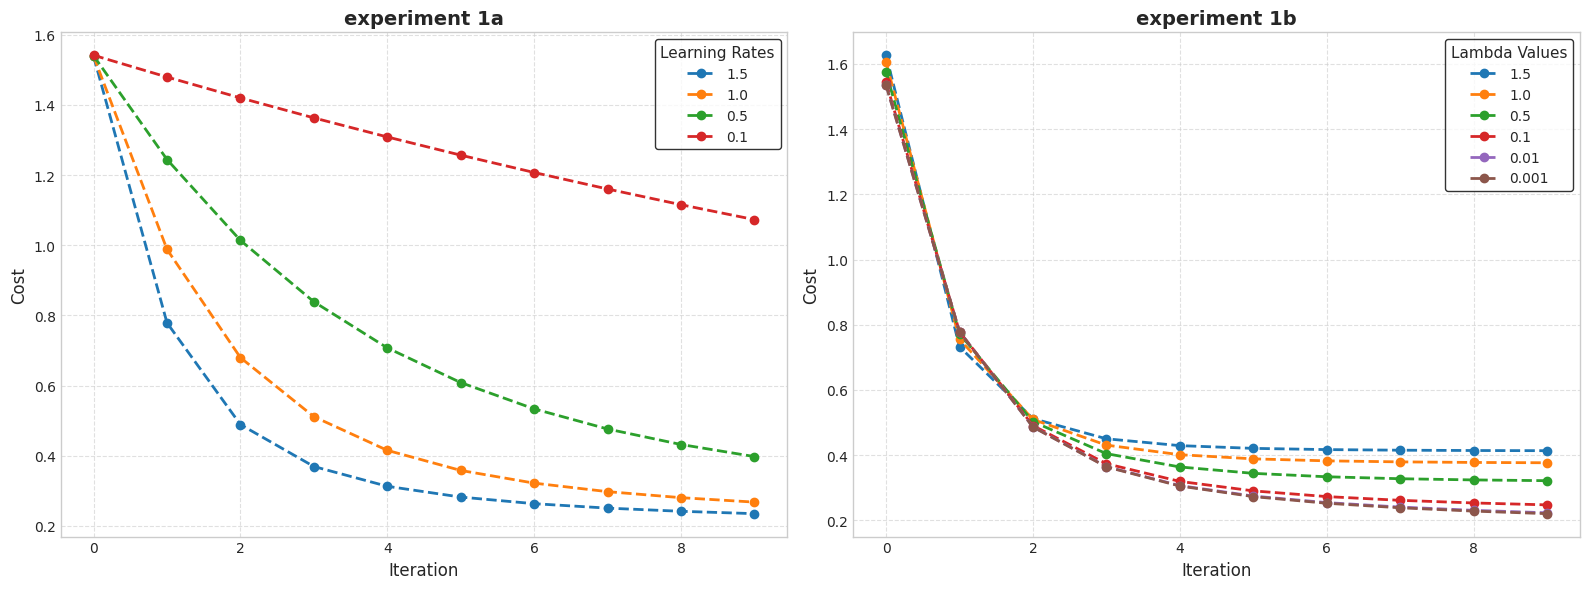

In [107]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
plt.style.use('seaborn-v0_8-whitegrid')

# First plot - experiment 1a
for lr, history in cost_functions.items():
    ax1.plot(history, linestyle='--', label=lr, marker='o', linewidth=2)

ax1.set_title("experiment 1a", fontsize=14, fontweight='bold')
ax1.set_xlabel('Iteration', fontsize=12)
ax1.set_ylabel('Cost', fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.legend(title="Learning Rates", title_fontsize=11, fontsize=10, 
           loc='upper right', frameon=True, facecolor='white', edgecolor='black')

# Second plot - experiment 1b
for lr, history in cost_functions_r.items():
    ax2.plot(history, linestyle='--', label=lr, marker='o', linewidth=2)

ax2.set_title("experiment 1b", fontsize=14, fontweight='bold')
ax2.set_xlabel('Iteration', fontsize=12)
ax2.set_ylabel('Cost', fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.6)
ax2.legend(title="Lambda Values", title_fontsize=11, fontsize=10, 
           loc='upper right', frameon=True, facecolor='white', edgecolor='black')

plt.tight_layout()
plt.show()

#### 2) Performance and speed-up analysis based on the number of workers and partitions (1 point)

• Generate a single graph with the performance and speed-up curves for different numbers of
workers and partitions, taking values in the range [1, 2, 3, ..., MaxCores + 3]. Alternatively,
additional values may be tested to identify the elbow of the curve and determine the optimal value.
    
• The performance curve shows execution time (y axis) versus number of workers (x axis). The
speedup curve shows the ratio (running time using 1 worker) /(running time using n workers) versus
the number of workers. Comment critically the results with respect to parallelization trying to
discover and explain changes in the behaviour of the curves.
    
• The same number of workers and partitions should be set for each point of the curve.

• RDDs should not be persisted (i.e., do not use cache() or persist()).
    
• It is recommended to use tools such as top or equivalents to verify that the worker processes are
executing correctly.
    
• Using getPartition() is recommended to ensure that the number of partitions in the RDD is as
expected.
    
• Explain the results observed for each dataset separately and then compare the results of both
datasets.

In [34]:
# experiment 2

# --- Configuration ---
N_ITERATIONS = 5
LEARNING_RATE = 1.5
LAMBDA_REG = 0.0
FILE_NAME = 'botnet_tot_syn_l.csv' 

execution_times = []
speed_up = []
num_cores_and_partitions = [1, 2, 3, 4, 5, 6, 8, 9, 10, 11] 
T1 = 0 # To store the execution time for 1 core/partition

# Set environment variables for PySpark
os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable

print(f"--- Running Experiment 2: Performance vs. Workers/Partitions ---")
print(f"Iterations: {N_ITERATIONS}, LR: {LEARNING_RATE}, Lambda: {LAMBDA_REG}")

for i in num_cores_and_partitions:
    
    # 1. STOP previous context to allow for new configuration
    try:
        pyspark.SparkContext._active_spark_context.stop()
    except:
        pass

    # 2. Configure SparkContext: set master to local[*] with i cores/workers 
    conf = (
    pyspark.SparkConf()
    .setMaster('local[{}]'.format(i)) 
    .setAppName(f'LR_{i}_workers')
    )
    
    sc = pyspark.SparkContext(conf=conf)
    
    # 3. Read data once per context
    data = readFile(FILE_NAME, sc)

    # 4. Repartition the data to match the number of workers/cores (i) 
    data_repartitioned = data.repartition(i)

    print(f"\n=== Running {i} Workers/Partitions ===")
    print(f"Workers (cores): {i}, Partitions: {data_repartitioned.getNumPartitions()}")
    
    # 5. START TIMING
    start_time = time.time()
    
    # STANDARDIZE 
    normalized_data, _, _ = normalize(data_repartitioned, sc) 

    # TRAIN (The main iterative cost)
    weights, bias, _ = train(normalized_data, N_ITERATIONS, LEARNING_RATE, LAMBDA_REG, sc)
    
    # ACCURACY (Final action to ensure full pipeline execution)
    accuracy(weights, bias, normalized_data, sc)

    # 6. END TIMING
    finish_time = time.time()
    execution_time = finish_time - start_time
    execution_times.append(execution_time)
    
    # 7. Calculate Speed-up
    if i == 1:
        T1 = execution_time
        current_speed_up = 1.0
    else:
        # Speedup is (running time using 1 worker) / (running time using n workers) 
        current_speed_up = T1 / execution_time
    
    speed_up.append(current_speed_up)

    # 8. Stop context
    sc.stop()

--- Running Experiment 2: Performance vs. Workers/Partitions ---
Iterations: 5, LR: 1.5, Lambda: 0.0

=== Running 1 Workers/Partitions ===
Workers (cores): 1, Partitions: 1


Iteration 0: Cost = 1.53202559423044


Iteration 1: Cost = 0.7781527414578288


Iteration 2: Cost = 0.4867155368754885


Iteration 3: Cost = 0.36455693659690286


Iteration 4: Cost = 0.3058750819252001



=== Running 2 Workers/Partitions ===
Workers (cores): 2, Partitions: 2


Iteration 0: Cost = 1.5320255942315646


Iteration 1: Cost = 0.7781527414585904


Iteration 2: Cost = 0.4867155368750091


Iteration 3: Cost = 0.36455693659660593


Iteration 4: Cost = 0.30587508192507407



=== Running 3 Workers/Partitions ===
Workers (cores): 3, Partitions: 3


Iteration 0: Cost = 1.5320255942298269


Iteration 1: Cost = 0.7781527414590208


Iteration 2: Cost = 0.4867155368757051


Iteration 3: Cost = 0.36455693659698113


Iteration 4: Cost = 0.3058750819252427



=== Running 4 Workers/Partitions ===
Workers (cores): 4, Partitions: 4


Iteration 0: Cost = 1.5320255942285277


Iteration 1: Cost = 0.7781527414592719


Iteration 2: Cost = 0.48671553687635255


Iteration 3: Cost = 0.36455693659736144


Iteration 4: Cost = 0.3058750819254435



=== Running 5 Workers/Partitions ===
Workers (cores): 5, Partitions: 5


Iteration 0: Cost = 1.5320255942285759


Iteration 1: Cost = 0.7781527414594543


Iteration 2: Cost = 0.48671553687644536


Iteration 3: Cost = 0.3645569365974039


Iteration 4: Cost = 0.30587508192547125



=== Running 6 Workers/Partitions ===
Workers (cores): 6, Partitions: 6


Iteration 0: Cost = 1.5320255942286765


Iteration 1: Cost = 0.7781527414596072


Iteration 2: Cost = 0.4867155368764601


Iteration 3: Cost = 0.36455693659741056


Iteration 4: Cost = 0.30587508192547935



=== Running 8 Workers/Partitions ===
Workers (cores): 8, Partitions: 8


Iteration 0: Cost = 1.5320255942288046


Iteration 1: Cost = 0.7781527414597638


Iteration 2: Cost = 0.48671553687644337


Iteration 3: Cost = 0.36455693659739064


Iteration 4: Cost = 0.30587508192547325



=== Running 9 Workers/Partitions ===
Workers (cores): 9, Partitions: 9


Iteration 0: Cost = 1.5320255942288847


Iteration 1: Cost = 0.7781527414597056


Iteration 2: Cost = 0.48671553687639485


Iteration 3: Cost = 0.3645569365973631


Iteration 4: Cost = 0.30587508192546164



=== Running 10 Workers/Partitions ===
Workers (cores): 10, Partitions: 10


Iteration 0: Cost = 1.5320255942289298


Iteration 1: Cost = 0.778152741459647


Iteration 2: Cost = 0.48671553687635144


Iteration 3: Cost = 0.3645569365973423


Iteration 4: Cost = 0.30587508192545176



=== Running 11 Workers/Partitions ===
Workers (cores): 11, Partitions: 11


Iteration 0: Cost = 1.5320255942289958


Iteration 1: Cost = 0.7781527414595826


Iteration 2: Cost = 0.4867155368763014


Iteration 3: Cost = 0.3645569365973171


Iteration 4: Cost = 0.3058750819254353


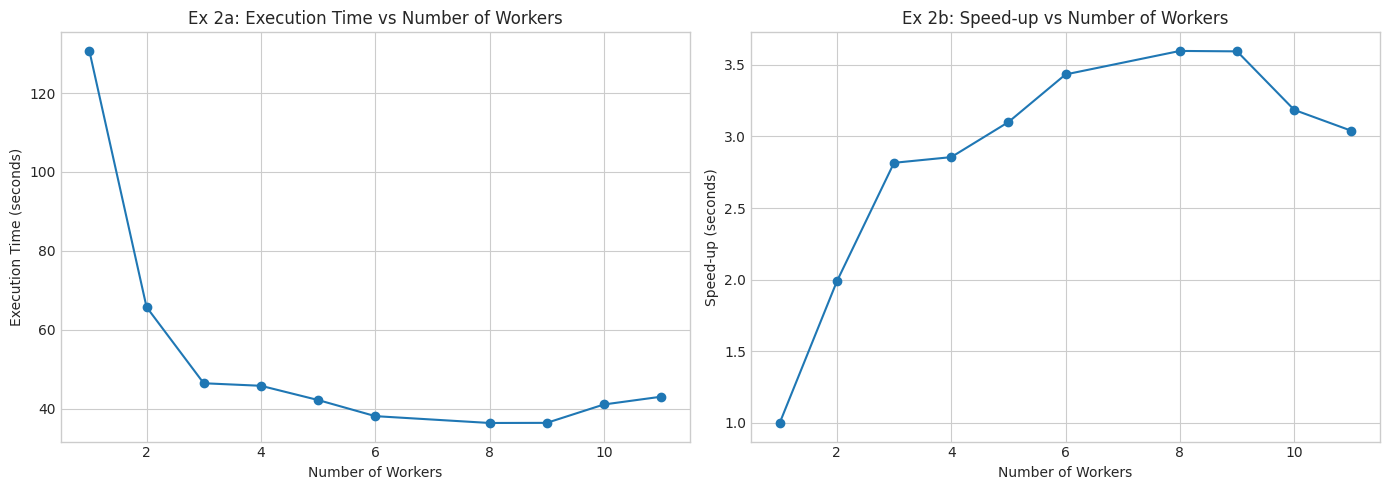

In [73]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
# First plot - Execution Time
ax1.plot(num_cores_and_partitions, execution_times, marker='o')
ax1.set_xlabel('Number of Workers')
ax1.set_ylabel('Execution Time (seconds)')
ax1.set_title('Ex 2a: Execution Time vs Number of Workers')
ax1.grid(True)
# Second plot - Speed-up
ax2.plot(num_cores_and_partitions, speed_up, marker='o')
ax2.set_xlabel('Number of Workers')
ax2.set_ylabel('Speed-up (seconds)')
ax2.set_title('Ex 2b: Speed-up vs Number of Workers')
ax2.grid(True)
plt.tight_layout()
plt.show()

#### 3) Use of the cache() function and its impact on execution time (1.5 points)
For this experiment, the optimal number of workers and partitions obtained in experiment 2 should be
used.

• Apply different caching strategies to the RDDs and determine which one offers the best performance
(shortest execution time) with the fewest calls to cache().

• Remember that the cache() function is not an action in Spark.

##### 3a) Bar chart of caching strategies (1 point)

Create a bar chart summarizing your results:

• X-axis: Caching strategy (e.g., “No cache”, “Cache after X”, “Cache after Y”, …).

• Y-axis: Execution time (in seconds).

• Label bars clearly; optionally add error bars if you repeat runs.

Explain the observed results (e.g., why the best strategy helps).

In [46]:
def run_pipeline_and_time_caching(path, nIter, learningRate, lambda_reg, strategy, sc):

    start_time = time.time()
    
    data = readFile(path, sc)
    
    # --- Apply Strategy A: Cache after ReadFile ---
    if strategy == "after_readFile":
        data.cache()
        data.count() # Force materialization


    # Repartition (Initial Shuffle/Setup)
    data_repartitioned = data.repartition(OPTIMAL_CORES)
    
    # --- Apply Strategy B: Cache after Repartition ---
    if strategy == "after_repartition":
        data_repartitioned.cache()
        data_repartitioned.count() # Force materialization

        
    
    
    # Normalization (The expensive, two-pass action)
    normalized_data, _, _ = normalize(data_repartitioned, sc)
    
    # --- Apply Strategy C: Cache after Normalization ---
    if strategy == "after_normalize":
        normalized_data.cache() 
        normalized_data.count() # Force materialization
        
    # Train and Accuracy (Iterative Actions)
    weights, bias, _ = train(normalized_data, nIter, learningRate, lambda_reg, sc)

    accuracy(weights, bias, normalized_data, sc)
    
    end_time = time.time()
    return end_time - start_time


In [47]:
# Cleanup at the start of each experiment
try:
    data_cache.unpersist()
    sc.stop()
    print("SparkContext stopped successfully")
except:
    pass
# -----------------------------------------------
conf = SparkConf().setAppName("Parallel_LR_Assessment")
sc = SparkContext.getOrCreate(conf=conf)
filename = "botnet_reduced_l.csv" 

OPTIMAL_CORES = 8 
N_ITERATIONS = 5

# Strategy D: No Cache
time_no_cache = run_pipeline_and_time_caching(filename, N_ITERATIONS, 1.5, 0.0, "no_cache", sc)

# Strategy A: Cache after Read
time_after_read = run_pipeline_and_time_caching(filename, N_ITERATIONS, 1.5, 0.0, "after_readFile", sc)

# Strategy B: Cache after Repartition
time_after_repartition = run_pipeline_and_time_caching(filename, N_ITERATIONS, 1.5, 0.0, "after_repartition", sc)

# Strategy C: Cache after Normalization
time_after_normalize = run_pipeline_and_time_caching(filename, N_ITERATIONS, 1.5, 0.0, "after_normalize", sc)


Iteration 0: Cost = 1.5337837156748273


Iteration 1: Cost = 0.7786560284539864


Iteration 2: Cost = 0.48637623455207185


Iteration 0: Cost = 1.5337837156748273


Iteration 1: Cost = 0.7786560284539864


Iteration 2: Cost = 0.48637623455207185


Iteration 0: Cost = 1.5337837156748273


Iteration 1: Cost = 0.7786560284539864


Iteration 2: Cost = 0.48637623455207185


Iteration 0: Cost = 1.5337837156748273


Iteration 1: Cost = 0.7786560284539864


Iteration 2: Cost = 0.48637623455207185


In [52]:
times = [time_no_cache, time_after_repartition, time_after_normalize, time_after_read]
strategies = ['no_cache', 'cache_after_repartition', 'cache_after_normalize', 'cache_after_readFile']

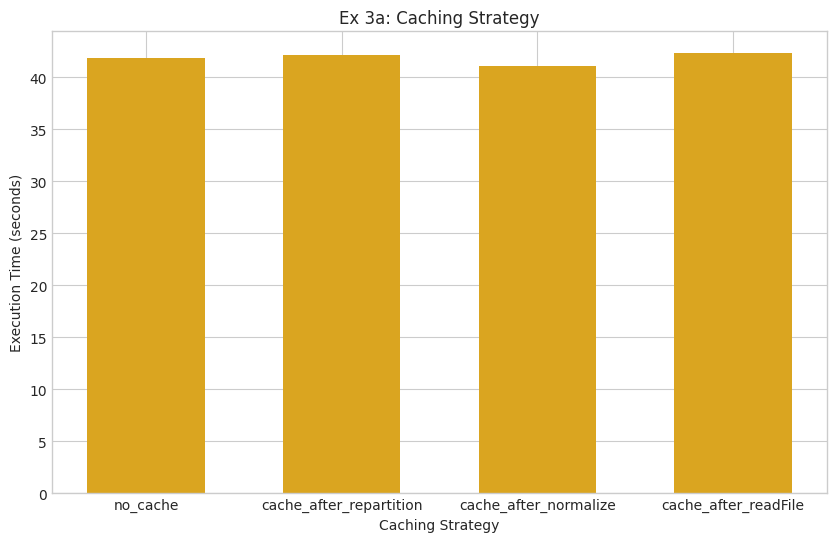

In [58]:
plt.figure(figsize=(10, 6))
plt.bar(strategies, times, color='goldenrod', width=0.6)
plt.xlabel('Caching Strategy')
plt.ylabel('Execution Time (seconds)')
plt.title('Ex 3a: Caching Strategy')
plt.grid(True)
plt.show()

##### 3b) Comparison between cache and no cache (0.5 points)

• Using the best caching strategy found in exercise 3a, recalculate the performance and speed-up
curves (defined in experiment 2).

• In the same graph, include the curve without caching (from experiment 2) and the optimal caching
curve.

• Explain and reason the differences in the results for each worker count when comparing cache vs. no
cache results.

In [54]:
# --- Configuration (Same as Experiment 2) ---
N_ITERATIONS = 3
LEARNING_RATE = 1.5
LAMBDA_REG = 0.0
FILE_NAME = 'botnet_tot_syn_l.csv'

# Workers/Partitions to test
num_cores_and_partitions = [1, 2, 3, 4, 5, 6, 8, 10, 12, 16] 

execution_times_cached = []
speed_up_cached = []
T1_cached = 0 # To store the execution time for 1 core/partition with cache

# Set environment variables for PySpark
os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable

print(f"--- Running Experiment 3b: Performance vs. Workers/Partitions (WITH CACHE) ---")
print(f"Iterations: {N_ITERATIONS}, LR: {LEARNING_RATE}, Lambda: {LAMBDA_REG}")

for i in num_cores_and_partitions:
    
    # 1. STOP previous context to allow for new configuration
    try:
        pyspark.SparkContext._active_spark_context.stop()
    except:
        pass

    # 2. Configure SparkContext: set master to local[i] cores/workers
    conf = (
        pyspark.SparkConf()
        .setMaster(f'local[{i}]') 
        .setAppName(f'LR_{i}_workers_CACHED')
    )
    
    sc = pyspark.SparkContext(conf=conf)
    
    # 3. Read data once per context
    data = readFile(FILE_NAME, sc)

    # 4. Repartition the data to match the number of workers/cores (i)
    data_repartitioned = data.repartition(i)

    print(f"\n=== Running {i} Workers/Partitions (CACHED) ===")
    
    # 5. START TIMING
    start_time = time.time()
    
    # STANDARDIZE (Forces the read and repartitioning)
    normalized_data, _, _ = normalize(data_repartitioned, sc)
    
    # CACHING STRATEGY: Cache after Normalize
    normalized_data.cache()
    normalized_data.count() 

    # TRAIN (The main iterative cost, now reading from cache)
    weights, bias, _ = train(normalized_data, N_ITERATIONS, LEARNING_RATE, LAMBDA_REG, sc)
    
    # ACCURACY (Final action)
    accuracy(weights, bias, normalized_data, sc)

    # 6. END TIMING
    finish_time = time.time()
    execution_time = finish_time - start_time
    execution_times_cached.append(execution_time)
    
    # 7. Calculate Speed-up
    if i == 1:
        T1_cached = execution_time
        current_speed_up = 1.0
    else:
        # Speedup is (running time using 1 worker) / (running time using n workers)
        current_speed_up = T1_cached / execution_time
    
    speed_up_cached.append(current_speed_up)

    # 8. Stop context
    sc.stop()


--- Running Experiment 3b: Performance vs. Workers/Partitions (WITH CACHE) ---
Iterations: 3, LR: 1.5, Lambda: 0.0

=== Running 1 Workers/Partitions (CACHED) ===


25/12/09 18:52:36 WARN BlockManager: Task 13 already completed, not releasing lock for rdd_10_0
                                                                                

Iteration 0: Cost = 1.53202559423044


Iteration 1: Cost = 0.7781527414578288


Iteration 2: Cost = 0.4867155368754885



=== Running 2 Workers/Partitions (CACHED) ===


25/12/09 18:53:57 WARN BlockManager: Task 17 already completed, not releasing lock for rdd_10_0
                                                                                

Iteration 0: Cost = 1.5320255942315646


Iteration 1: Cost = 0.7781527414585904


Iteration 2: Cost = 0.4867155368750091



=== Running 3 Workers/Partitions (CACHED) ===


25/12/09 18:54:48 WARN BlockManager: Task 21 already completed, not releasing lock for rdd_10_0
                                                                                

Iteration 0: Cost = 1.5320255942298269


Iteration 1: Cost = 0.7781527414590208


Iteration 2: Cost = 0.4867155368757051



=== Running 4 Workers/Partitions (CACHED) ===


25/12/09 18:55:28 WARN BlockManager: Task 25 already completed, not releasing lock for rdd_10_0
                                                                                

Iteration 0: Cost = 1.5320255942285277


Iteration 1: Cost = 0.7781527414592719


Iteration 2: Cost = 0.48671553687635255



=== Running 5 Workers/Partitions (CACHED) ===


25/12/09 18:56:03 WARN BlockManager: Task 29 already completed, not releasing lock for rdd_10_0
                                                                                

Iteration 0: Cost = 1.5320255942285759


Iteration 1: Cost = 0.7781527414594543


Iteration 2: Cost = 0.48671553687644536



=== Running 6 Workers/Partitions (CACHED) ===


25/12/09 18:56:39 WARN BlockManager: Task 33 already completed, not releasing lock for rdd_10_0
                                                                                

Iteration 0: Cost = 1.5320255942286765


Iteration 1: Cost = 0.7781527414596072


Iteration 2: Cost = 0.4867155368764601



=== Running 8 Workers/Partitions (CACHED) ===


25/12/09 18:57:10 WARN BlockManager: Task 41 already completed, not releasing lock for rdd_10_0
                                                                                

Iteration 0: Cost = 1.5320255942288046


Iteration 1: Cost = 0.7781527414597638


Iteration 2: Cost = 0.48671553687644337



=== Running 10 Workers/Partitions (CACHED) ===


25/12/09 18:57:39 WARN BlockManager: Task 49 already completed, not releasing lock for rdd_10_0
                                                                                

Iteration 0: Cost = 1.5320255942289298


Iteration 1: Cost = 0.778152741459647


Iteration 2: Cost = 0.48671553687635144



=== Running 12 Workers/Partitions (CACHED) ===


25/12/09 18:58:18 WARN BlockManager: Task 57 already completed, not releasing lock for rdd_10_0
                                                                                

Iteration 0: Cost = 1.5320255942290857


Iteration 1: Cost = 0.7781527414595324


Iteration 2: Cost = 0.4867155368762504



=== Running 16 Workers/Partitions (CACHED) ===


25/12/09 18:58:53 WARN BlockManager: Task 73 already completed, not releasing lock for rdd_10_0
                                                                                

Iteration 0: Cost = 1.532025594229404


Iteration 1: Cost = 0.778152741459364


Iteration 2: Cost = 0.4867155368760698


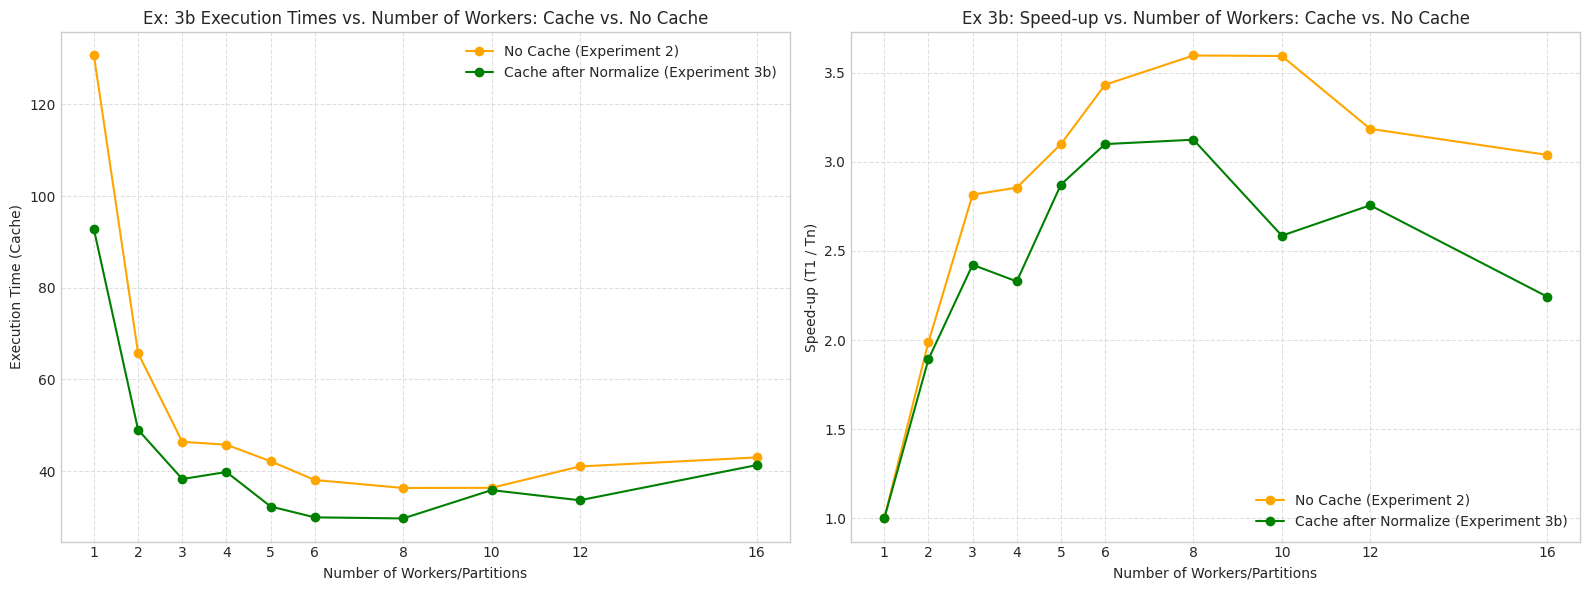

In [60]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# First plot - Execution Times
ax1.plot(num_cores_and_partitions, execution_times, 
         label='No Cache (Experiment 2)', marker='o', linestyle='-', color='orange')
ax1.plot(num_cores_and_partitions, execution_times_cached, 
         label='Cache after Normalize (Experiment 3b)', marker='o', linestyle='-', color='green')
ax1.set_title('Ex: 3b Execution Times vs. Number of Workers: Cache vs. No Cache')
ax1.set_xlabel('Number of Workers/Partitions')
ax1.set_ylabel('Execution Time (Cache)')
ax1.legend()
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.set_xticks(num_cores_and_partitions)

# Second plot - Speed-up
ax2.plot(num_cores_and_partitions, speed_up, 
         label='No Cache (Experiment 2)', marker='o', linestyle='-', color='orange')
ax2.plot(num_cores_and_partitions, speed_up_cached, 
         label='Cache after Normalize (Experiment 3b)', marker='o', linestyle='-', color='green')
ax2.set_title('Ex 3b: Speed-up vs. Number of Workers: Cache vs. No Cache')
ax2.set_xlabel('Number of Workers/Partitions')
ax2.set_ylabel('Speed-up (T1 / Tn)')
ax2.legend()
ax2.grid(True, linestyle='--', alpha=0.6)
ax2.set_xticks(num_cores_and_partitions)

plt.tight_layout()
plt.show()

#### 4) Study of the effect of the number of partitions (0.5 points)

• Set the number of workers to 4 and vary the number of partitions in [1, 2, 3, 4, 5, 6, 7, 8].

• Generate a graph where:

o X-axis: Number of partitions.

o Y-axis: Execution time.

• Analyze whether increasing or decreasing the number of partitions improves performance. Explain
and justify the observed results in the graph.

In [85]:
# --- Configuration ---
FIXED_WORKERS = 4 
N_ITERATIONS = 2
LEARNING_RATE = 1.5
LAMBDA_REG = 0.0 
FILE_NAME = 'botnet_tot_syn_l.csv'

execution_times_partitions = []
num_partitions_list = [1, 2, 3, 4, 5, 6, 7, 8] 

# Set environment variables for PySpark
os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable

print(f"--- Running Experiment 4: Performance vs. Partitions (Workers fixed at {FIXED_WORKERS}) ---")

# 1. Configure and Create SparkContext (Done only once since workers are fixed)
try:
    pyspark.SparkContext._active_spark_context.stop()
except:
    pass

conf = (
    pyspark.SparkConf()
    # Fix the master to run with 4 cores
    .setMaster(f'local[{FIXED_WORKERS}]') 
    .setAppName(f'LR_Fixed_{FIXED_WORKERS}W_Partitions')
)
sc = pyspark.SparkContext(conf=conf)
    
# 2. Read the source data RDD once
data = readFile(FILE_NAME, sc)

# 3. Loop through varying partition counts
for P in num_partitions_list:
    
    # 4. Repartition the data RDD to the current partition count (P)
    data_repartitioned = data.repartition(P)

    print(f"\n=== Running {FIXED_WORKERS} Workers / {P} Partitions ===")
    print(f"Actual Partitions: {data_repartitioned.getNumPartitions()}")
    
    # 5. START TIMING
    start_time = time.time()
    
    # STANDARDIZE 
    normalized_data, _, _ = normalize(data_repartitioned, sc) 

    # TRAIN 
    weights, bias, _ = train(normalized_data, N_ITERATIONS, LEARNING_RATE, LAMBDA_REG, sc)
    
    # ACCURACY 
    accuracy(weights, bias, normalized_data, sc)

    # 6. END TIMING
    finish_time = time.time()
    execution_time = finish_time - start_time
    execution_times_partitions.append(execution_time)
    
    print(f"Execution Time: {execution_time:.2f}s")
    
sc.stop()

--- Running Experiment 4: Performance vs. Partitions (Workers fixed at 4) ---

=== Running 4 Workers / 1 Partitions ===
Actual Partitions: 1


Iteration 0: Cost = 1.53202559423044


Iteration 1: Cost = 0.7781527414578288


Execution Time: 64.51s

=== Running 4 Workers / 2 Partitions ===
Actual Partitions: 2


Iteration 0: Cost = 1.5320255942315646


Iteration 1: Cost = 0.7781527414585904


Execution Time: 33.54s

=== Running 4 Workers / 3 Partitions ===
Actual Partitions: 3


Iteration 0: Cost = 1.5320255942298269


Iteration 1: Cost = 0.7781527414590208


Execution Time: 25.34s

=== Running 4 Workers / 4 Partitions ===
Actual Partitions: 4


Iteration 0: Cost = 1.5320255942285277


Iteration 1: Cost = 0.7781527414592719


Execution Time: 22.20s

=== Running 4 Workers / 5 Partitions ===
Actual Partitions: 5


Iteration 0: Cost = 1.5320255942285759


Iteration 1: Cost = 0.7781527414594543


Execution Time: 31.12s

=== Running 4 Workers / 6 Partitions ===
Actual Partitions: 6


Iteration 0: Cost = 1.5320255942286765


Iteration 1: Cost = 0.7781527414596072


Execution Time: 25.61s

=== Running 4 Workers / 7 Partitions ===
Actual Partitions: 7


Iteration 0: Cost = 1.5320255942287122


Iteration 1: Cost = 0.778152741459735


Execution Time: 24.53s

=== Running 4 Workers / 8 Partitions ===
Actual Partitions: 8


Iteration 0: Cost = 1.5320255942288046


Iteration 1: Cost = 0.7781527414597638


Execution Time: 1122.74s


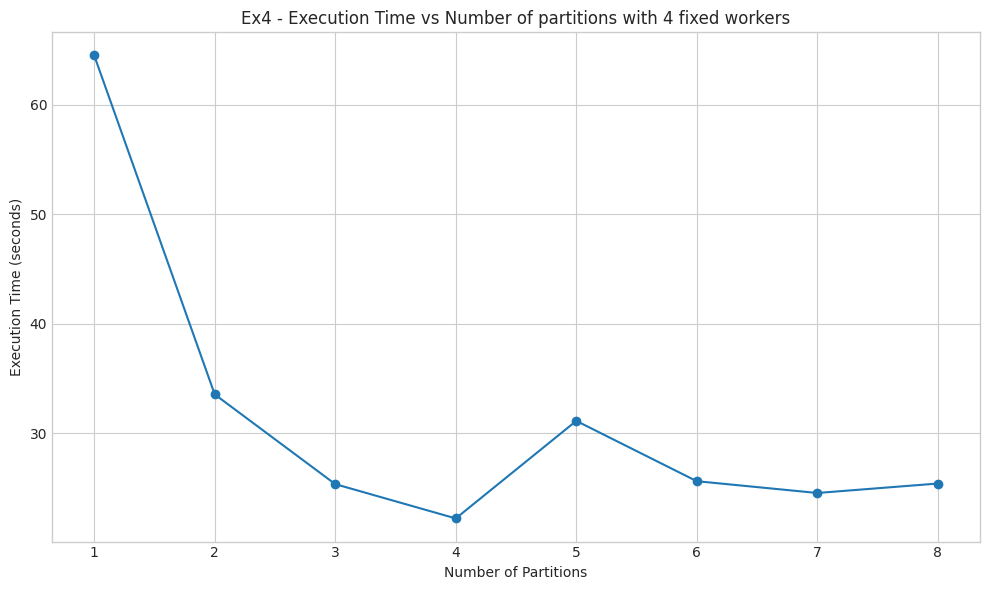

In [103]:
plt.figure(figsize=(10, 6))
plt.plot(num_partitions_list, execution_times_partitions, marker='o')
plt.xlabel('Number of Partitions')
plt.ylabel('Execution Time (seconds)')
plt.title('Ex4 - Execution Time vs Number of partitions with 4 fixed workers')
plt.grid(True)
plt.tight_layout()
plt.show()

#### 5) Study of the effect of the number of workers (0.5 points)

• Set the number of partitions to 2 and vary the number of workers in [1, 2, 3, ..., MaxCores + 3].

• Generate a graph where:
    
- X-axis: Number of workers.
    
- Y-axis: Execution time.
    
• Analyze whether increasing or decreasing the number of workers improves performance. Explain
and justify the observed results in the graph.

In [80]:
# --- Configuration ---
FIXED_PARTITIONS = 2 
N_ITERATIONS = 5
LEARNING_RATE = 1.5
LAMBDA_REG = 0.0 
FILE_NAME = 'botnet_tot_syn_l.csv'

execution_times_workers = []
# MaxCores + 2.
num_workers_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11] 

# Set environment variables for PySpark
os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable

# 1. Loop through varying worker counts
for W in num_workers_list:
    
    # 2. STOP previous context
    try:
        pyspark.SparkContext._active_spark_context.stop()
    except:
        pass

    # 3. Configure SparkContext: set master to local[W] cores/workers
    conf = (
        pyspark.SparkConf()
        # Set the number of workers to W
        .setMaster(f'local[{W}]') 
        .setAppName(f'LR_{W}W_Fixed_{FIXED_PARTITIONS}P')
    )
    sc = pyspark.SparkContext(conf=conf)
    
    # 4. Read the data RDD once
    data = readFile(FILE_NAME, sc)

    # 5. Repartition the data to the FIXED partition count 
    data_repartitioned = data.repartition(FIXED_PARTITIONS)

    print(f"\n=== Running {W} Workers / {FIXED_PARTITIONS} Partitions ===")
    
    # 6. START TIMING
    start_time = time.time()
    
    # STANDARDIZE (Forces repartitioning/shuffle)
    normalized_data, _, _ = normalize(data_repartitioned, sc) 

    # TRAIN (The main iterative cost)
    weights, bias, _ = train(normalized_data, N_ITERATIONS, LEARNING_RATE, LAMBDA_REG, sc)
    
    # ACCURACY (Final action)
    accuracy(weights, bias, normalized_data, sc)

    # 7. END TIMING
    finish_time = time.time()
    execution_time = finish_time - start_time
    execution_times_workers.append(execution_time)
    
    print(f"Execution Time: {execution_time:.2f}s")
    
# 8. Print Final Results and Stop Context
print("\n--- Results Summary ---")
print(f"Execution Times: {execution_times_workers}")

sc.stop()



=== Running 1 Workers / 2 Partitions ===


Iteration 0: Cost = 1.5320255942315646


Execution Time: 50.90s

=== Running 2 Workers / 2 Partitions ===


Iteration 0: Cost = 1.5320255942315646


Execution Time: 25.42s

=== Running 3 Workers / 2 Partitions ===


Iteration 0: Cost = 1.5320255942315646


Execution Time: 25.10s

=== Running 4 Workers / 2 Partitions ===


Iteration 0: Cost = 1.5320255942315646


Execution Time: 24.96s

=== Running 5 Workers / 2 Partitions ===


Iteration 0: Cost = 1.5320255942315646


Execution Time: 27.90s

=== Running 6 Workers / 2 Partitions ===


Iteration 0: Cost = 1.5320255942315646


Execution Time: 25.33s

=== Running 7 Workers / 2 Partitions ===


Iteration 0: Cost = 1.5320255942315646


Execution Time: 26.04s

=== Running 8 Workers / 2 Partitions ===


Iteration 0: Cost = 1.5320255942315646


Execution Time: 25.12s

=== Running 9 Workers / 2 Partitions ===


Iteration 0: Cost = 1.5320255942315646


Execution Time: 25.60s

=== Running 10 Workers / 2 Partitions ===


Iteration 0: Cost = 1.5320255942315646


Execution Time: 26.46s

=== Running 11 Workers / 2 Partitions ===


Iteration 0: Cost = 1.5320255942315646


Execution Time: 26.20s

--- Results Summary ---
Execution Times: [50.896095514297485, 25.418981313705444, 25.095857620239258, 24.963100910186768, 27.90105700492859, 25.33492684364319, 26.044111251831055, 25.122851133346558, 25.60334801673889, 26.46124577522278, 26.199097871780396]


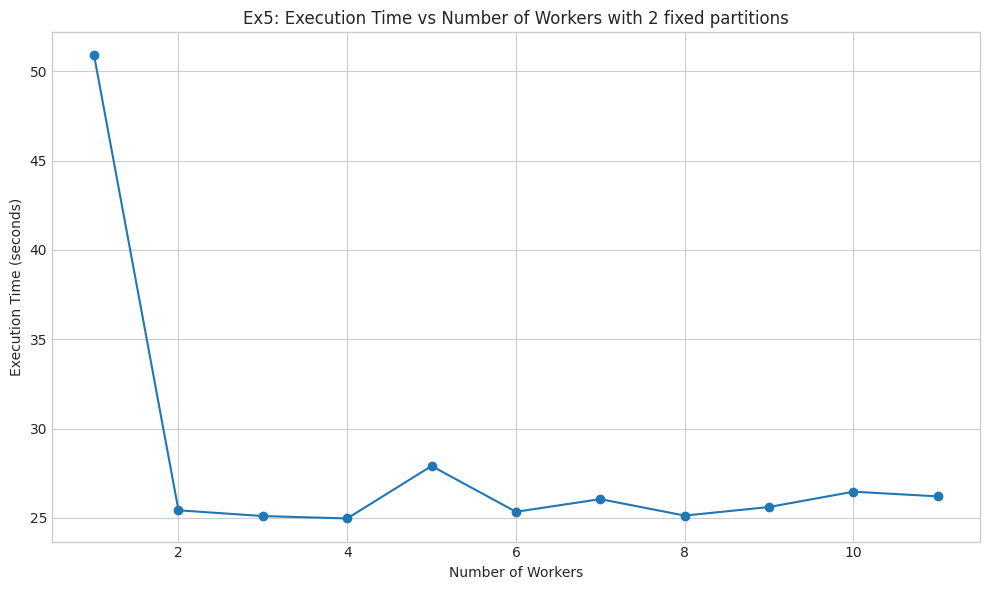

In [84]:
plt.figure(figsize=(10, 6))
plt.plot(num_workers_list, execution_times_workers, marker='o')
plt.xlabel('Number of Workers')
plt.ylabel('Execution Time (seconds)')
plt.title('Ex5: Execution Time vs Number of Workers with 2 fixed partitions')
plt.tight_layout()
plt.grid(True)
plt.show()

#### 6) Code submission

The code used to perform the different experiments (1, 2, 3, 4 and 5) must be submitted.

In addition to the written report, separate jupyter notebooks will be delivered for the parallelized version and
the code used for deploying the experiments (1, 2, 3, 4 and 5) of the written report.

In [12]:
#to do 